<a href="https://colab.research.google.com/github/eedduu/TFG/blob/main/code/BreastCancerWins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Breast Cancer Wisconsin Dataset

In [2]:
#Install dependencies
!pip install fastai
!pip install nbdev
!pip install ucimlrepo

#Import libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import fastai
from fastai.tabular.all import *
import torch.nn.functional as F
import torch.nn as nn
import pickle

#Convert and import personalised library
!jupyter nbconvert --to python /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.ipynb --output utilsTFG.py
!cp /content/drive/MyDrive/Colab\ Notebooks/utilsTFG.py .
import utilsTFG


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/utilsTFG.ipynb to python
[NbConvertApp] Writing 39956 bytes to /content/drive/MyDrive/Colab Notebooks/utilsTFG.py
Processing ./drive/MyDrive/pyade-master
  Preparing metadata (setup.py) ... done
  Created wheel for pyade-python: filename=pyade_python-1.0-py3-none-any.whl size=29087 sha256=5927b317f999788bab0c65e5866ca52d41298a18d768b7ba1c8bb9f473bfe1de
  Stored in directory: /root/.cache/pip/wheels/89/b8/51/ff2ebef24405d3ef46ccb451f962b374b2745f263fb000c434
Successfully built pyade-python


### Datos y modelos

In [7]:
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)

X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

#Show the data
print(X.head())




# metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

# variable information
print(breast_cancer_wisconsin_diagnostic.variables)

df=pd.concat([X, y], axis=1)

# Define the categorical and continuous variables
cat_names = []
cont_names = list(X.columns)
dep_var = 'Diagnosis'

# Split indices for training, validation, and test sets
train_val_split = RandomSplitter(valid_pct=0.3)(range_of(df))  # 70% for training/validation, 30% for testing
train_idx, val_test_idx = train_val_split

# Now split the validation/test set into validation and test sets (50% each)
val_test_split = RandomSplitter(valid_pct=0.5)(val_test_idx)
val_idx, test_idx = val_test_split

# Combine all indices for the splits
splits = (train_idx, val_idx)

# Create TabularPandas for training and validation
to = TabularPandas(
    df,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    splits=splits
)

# Create TabularPandas for training and validation to be used in MH
to_mh = TabularPandas(
    df,
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
)

# Create DataLoaders for training and validation
dls = to.dataloaders(bs=16, shuffle=True)

dls_mh = to_mh.dataloaders(bs=16, shuffle=True)

test_to = TabularPandas(
    df.iloc[test_idx],  # Select only the test data
    procs=[Categorify, FillMissing, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var
)

# Create a DataLoader for the test set. Dont shuffle to get a more objective value across computations
test_dl = test_to.dataloaders(bs=16, shuffle=False)

   radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3    11.42     20.38       77.58   386.1      0.14250       0.28390   
4    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  fractal_dimension1  ...  radius3  \
0      0.3001          0.14710     0.2419             0.07871  ...    25.38   
1      0.0869          0.07017     0.1812             0.05667  ...    24.99   
2      0.1974          0.12790     0.2069             0.05999  ...    23.57   
3      0.2414          0.10520     0.2597             0.09744  ...    14.91   
4      0.1980          0.10430     0.1809             0.05883  ...    22.54   

   texture3  perimeter3   area3  smoothness3  compactness3  concavity3  \
0     17.33      184.60 

In [9]:
#Create array of 1, 2, 5 and 15 hidden layers for MLP
layers = [[32], [32, 32], [32, 64, 128, 64, 32], [16, 32, 64, 128, 256, 512, 1024, 2048, 1024, 512, 256, 128, 64, 32, 16] ]
n_layers=[1,2,5,15]
optims = ['NAG', 'RMSProp', 'ADAM']
names_layer=['1 layer', '2 layers', '5 layers', '15 layers']
algs = ['SHADE', 'SHADE-ILS', 'SHADE-GD', 'SHADE-ILS-GD']

## Gradient Descent

In [10]:
# Define the optimizers
NAG = partial(OptimWrapper, opt=torch.optim.SGD, momentum=0.9, nesterov=True)
RMSProp = partial(OptimWrapper, opt=torch.optim.RMSprop)
ADAM = partial(OptimWrapper, opt=torch.optim.Adam)
optims2 = [NAG, RMSProp, ADAM]

# Initialize the learners dictionary
learners = {}

# Iterate over the optimizers and layers to create learners
for opt, opt2 in zip(optims, optims2):
    learners[opt] = {}  # Initialize the dictionary for this optimizer
    for layer in layers:
        learners[opt][len(layer)] = tabular_learner(dls=dls, layers=layer, metrics=accuracy, opt_func=opt2, cbs=[EarlyStoppingCallback(patience=5), SaveModelCallback()])


### Nesterov

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.605993,0.541784,0.764706,00:00
1,0.506890,0.331938,0.917647,00:00
2,0.416641,0.241621,0.941176,00:00
3,0.342265,0.205955,0.952941,00:00
4,0.293159,0.170253,0.964706,00:00
5,0.249628,0.137574,0.952941,00:00
6,0.254078,0.128421,0.964706,00:00
7,0.222620,0.116227,0.988235,00:00
8,0.227615,0.119991,0.976471,00:00
9,0.206146,0.100208,0.976471,00:00


Better model found at epoch 0 with valid_loss value: 0.54178386926651.
Better model found at epoch 1 with valid_loss value: 0.33193784952163696.
Better model found at epoch 2 with valid_loss value: 0.2416212260723114.
Better model found at epoch 3 with valid_loss value: 0.20595546066761017.
Better model found at epoch 4 with valid_loss value: 0.17025285959243774.
Better model found at epoch 5 with valid_loss value: 0.13757376372814178.
Better model found at epoch 6 with valid_loss value: 0.1284209042787552.
Better model found at epoch 7 with valid_loss value: 0.11622688174247742.
Better model found at epoch 9 with valid_loss value: 0.10020824521780014.
Better model found at epoch 10 with valid_loss value: 0.09333900362253189.
Better model found at epoch 12 with valid_loss value: 0.09222595393657684.
Better model found at epoch 13 with valid_loss value: 0.08522892743349075.
Better model found at epoch 14 with valid_loss value: 0.06007644534111023.
No improvement since epoch 14: early st

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.519888,0.427728,0.894118,00:01
1,0.373440,0.242411,0.905882,00:01
2,0.327252,0.187924,0.929412,00:00
3,0.276453,0.160907,0.929412,00:00
4,0.241002,0.123444,0.976471,00:00
5,0.208606,0.106686,0.964706,00:00
6,0.201582,0.095709,0.964706,00:00
7,0.180238,0.110304,0.941176,00:00
8,0.147156,0.094859,0.976471,00:00
9,0.146594,0.063068,0.976471,00:00


Better model found at epoch 0 with valid_loss value: 0.42772796750068665.
Better model found at epoch 1 with valid_loss value: 0.24241091310977936.
Better model found at epoch 2 with valid_loss value: 0.18792395293712616.
Better model found at epoch 3 with valid_loss value: 0.16090749204158783.
Better model found at epoch 4 with valid_loss value: 0.1234436184167862.
Better model found at epoch 5 with valid_loss value: 0.10668550431728363.
Better model found at epoch 6 with valid_loss value: 0.09570890665054321.
Better model found at epoch 8 with valid_loss value: 0.09485899657011032.
Better model found at epoch 9 with valid_loss value: 0.06306823343038559.
Better model found at epoch 10 with valid_loss value: 0.05581352487206459.
Better model found at epoch 13 with valid_loss value: 0.05358383059501648.
Better model found at epoch 14 with valid_loss value: 0.0485403835773468.
No improvement since epoch 14: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.569552,0.631376,0.541176,00:00
1,0.501254,0.413309,0.811765,00:00
2,0.416624,0.282351,0.964706,00:00
3,0.352198,0.253334,0.929412,00:00
4,0.301723,0.218557,0.964706,00:00
5,0.261047,0.177457,0.964706,00:00
6,0.244649,0.162555,0.941176,00:00
7,0.218054,0.133000,0.964706,00:00
8,0.194759,0.170375,0.952941,00:01
9,0.182427,0.149096,0.952941,00:01


Better model found at epoch 0 with valid_loss value: 0.6313762664794922.
Better model found at epoch 1 with valid_loss value: 0.4133085012435913.
Better model found at epoch 2 with valid_loss value: 0.282351016998291.
Better model found at epoch 3 with valid_loss value: 0.2533337473869324.
Better model found at epoch 4 with valid_loss value: 0.21855704486370087.
Better model found at epoch 5 with valid_loss value: 0.1774565577507019.
Better model found at epoch 6 with valid_loss value: 0.16255474090576172.
Better model found at epoch 7 with valid_loss value: 0.13299968838691711.
No improvement since epoch 7: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.683834,0.686391,0.564706,00:02
1,0.598119,0.504866,0.800000,00:02
2,0.528820,0.423833,0.811765,00:01
3,0.461757,0.354814,0.894118,00:01
4,0.401756,0.317996,0.894118,00:01
5,0.366957,0.246720,0.929412,00:01
6,0.330682,0.298471,0.870588,00:01
7,0.303662,0.420673,0.847059,00:01
8,0.266938,0.331008,0.894118,00:02
9,0.258870,0.305177,0.894118,00:02


Better model found at epoch 0 with valid_loss value: 0.6863905191421509.
Better model found at epoch 1 with valid_loss value: 0.5048662424087524.
Better model found at epoch 2 with valid_loss value: 0.4238330125808716.
Better model found at epoch 3 with valid_loss value: 0.3548144996166229.
Better model found at epoch 4 with valid_loss value: 0.3179958462715149.
Better model found at epoch 5 with valid_loss value: 0.24671974778175354.
Better model found at epoch 10 with valid_loss value: 0.20555610954761505.
Better model found at epoch 11 with valid_loss value: 0.20537477731704712.
Better model found at epoch 15 with valid_loss value: 0.1503722369670868.
No improvement since epoch 15: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

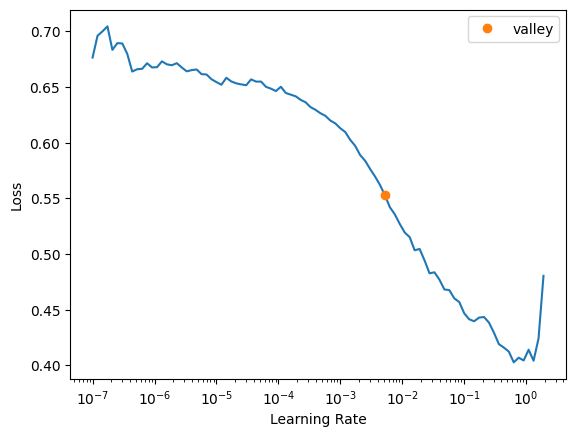

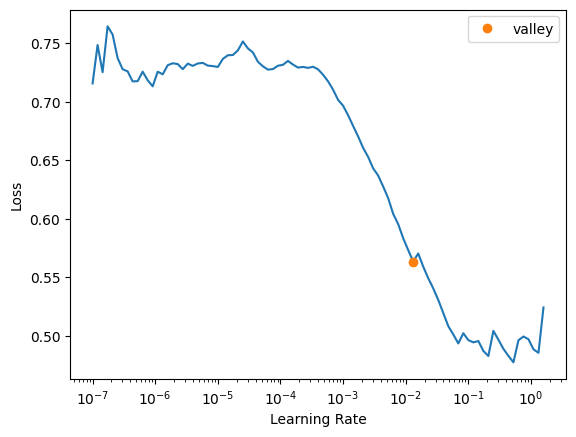

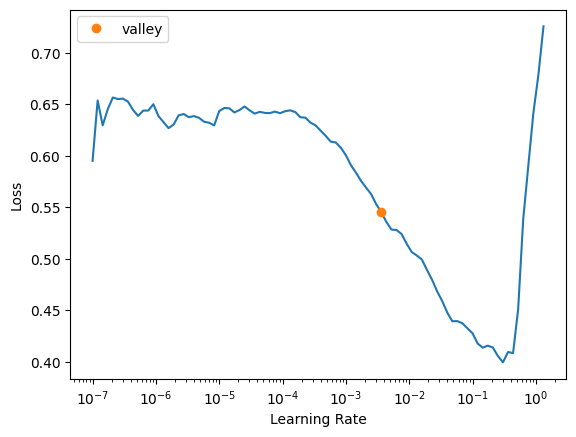

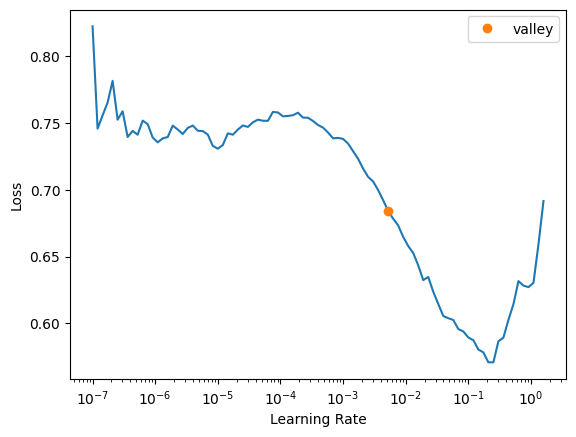

In [11]:
#Pruebas, pero tampoco tendría que hacer mucho más ya en teoría.
for _, learner in learners['NAG'].items():
  lr=learner.lr_find()
  learner.fit_one_cycle(100, lr)



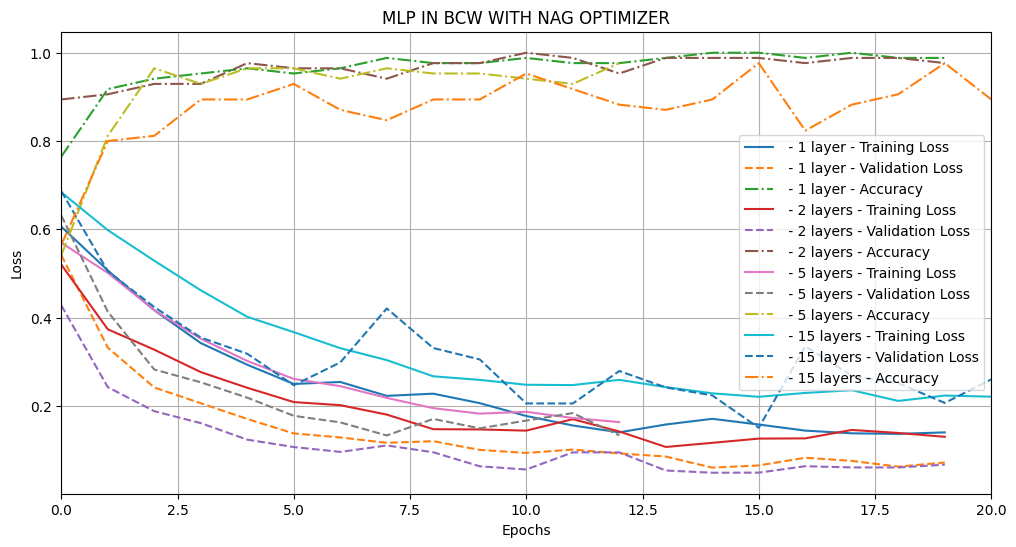

In [12]:
utilsTFG.plot_learners_training(learners['NAG'].values(), title='MLP IN BCW WITH NAG OPTIMIZER', names=names_layer)

### RMSProp

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.313304,0.130509,0.952941,00:00
1,0.211782,0.064226,1.000000,00:00
2,0.182802,0.068445,0.976471,00:00
3,0.189379,0.080557,0.988235,00:00
4,0.178103,0.080573,0.988235,00:00
5,0.168066,0.061136,1.000000,00:00
6,0.159402,0.097563,0.976471,00:00
7,0.144992,0.081619,0.988235,00:00
8,0.180149,0.116326,0.964706,00:00
9,0.153460,0.062596,0.988235,00:00


Better model found at epoch 0 with valid_loss value: 0.13050857186317444.
Better model found at epoch 1 with valid_loss value: 0.06422646343708038.
Better model found at epoch 5 with valid_loss value: 0.061136238276958466.
Better model found at epoch 10 with valid_loss value: 0.0270010307431221.
No improvement since epoch 10: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.324552,0.205102,0.976471,00:00
1,0.220951,0.078111,0.988235,00:00
2,0.189695,0.067462,0.988235,00:00
3,0.188419,0.068475,0.976471,00:00
4,0.185590,0.082439,0.988235,00:00
5,0.182529,0.090554,0.988235,00:00
6,0.161428,0.072986,0.976471,00:00
7,0.129562,0.055702,0.988235,00:00
8,0.122201,0.046741,0.976471,00:00
9,0.146885,0.061340,0.988235,00:00


Better model found at epoch 0 with valid_loss value: 0.20510248839855194.
Better model found at epoch 1 with valid_loss value: 0.07811128348112106.
Better model found at epoch 2 with valid_loss value: 0.06746207922697067.
Better model found at epoch 7 with valid_loss value: 0.05570179969072342.
Better model found at epoch 8 with valid_loss value: 0.04674076661467552.
Better model found at epoch 13 with valid_loss value: 0.03827730938792229.
No improvement since epoch 13: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.394540,0.351688,0.941176,00:00
1,0.283093,0.107716,0.976471,00:00
2,0.261607,0.083685,0.988235,00:00
3,0.223549,0.095288,0.964706,00:00
4,0.213795,0.103777,0.976471,00:00
5,0.208394,0.113270,0.976471,00:00
6,0.181782,0.098409,0.976471,00:00
7,0.180528,0.052330,0.976471,00:00
8,0.186194,0.129199,0.976471,00:01
9,0.171321,0.068801,0.988235,00:02


Better model found at epoch 0 with valid_loss value: 0.351688414812088.
Better model found at epoch 1 with valid_loss value: 0.10771627724170685.
Better model found at epoch 2 with valid_loss value: 0.08368528634309769.
Better model found at epoch 7 with valid_loss value: 0.05232950672507286.
No improvement since epoch 7: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.579862,0.666032,0.647059,00:06
1,0.499395,0.388642,0.882353,00:03
2,0.400953,0.309347,0.882353,00:01
3,0.358133,0.301237,0.905882,00:02
4,0.331265,0.247291,0.894118,00:02
5,0.336196,0.281727,0.858824,00:03
6,0.312726,0.243118,0.929412,00:03
7,0.288431,0.197609,0.929412,00:01
8,0.273157,0.220732,0.894118,00:02
9,0.279667,0.231105,0.929412,00:02


Better model found at epoch 0 with valid_loss value: 0.6660317182540894.
Better model found at epoch 1 with valid_loss value: 0.38864240050315857.
Better model found at epoch 2 with valid_loss value: 0.30934733152389526.
Better model found at epoch 3 with valid_loss value: 0.3012368977069855.
Better model found at epoch 4 with valid_loss value: 0.24729058146476746.
Better model found at epoch 6 with valid_loss value: 0.2431180626153946.
Better model found at epoch 7 with valid_loss value: 0.19760915637016296.
Better model found at epoch 10 with valid_loss value: 0.08967846632003784.
No improvement since epoch 10: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

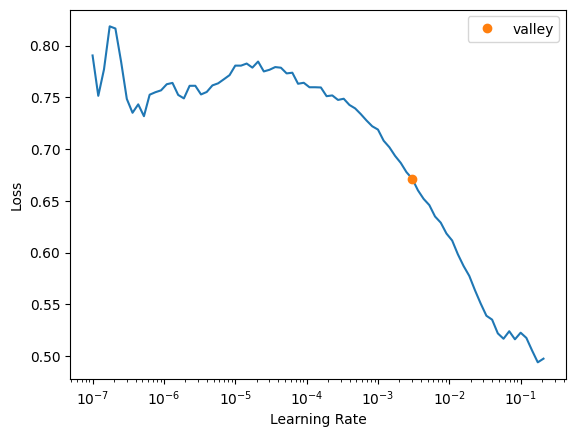

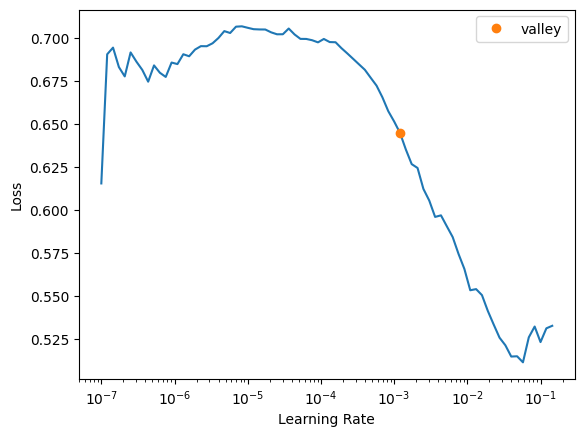

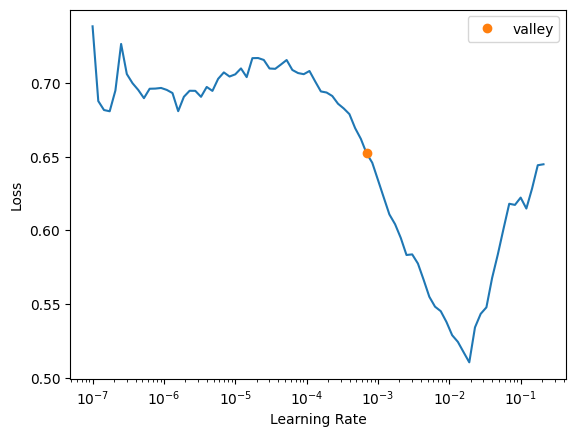

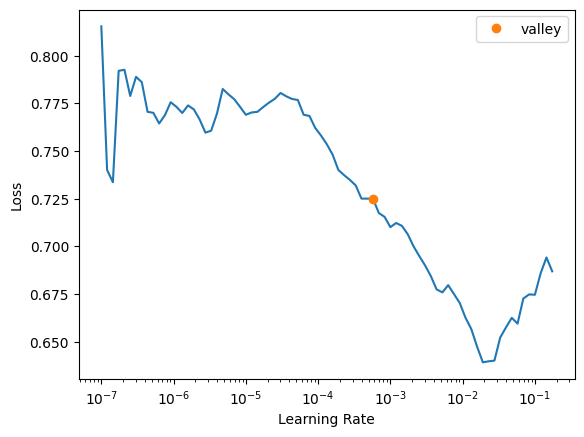

In [13]:
for _, learner in learners['RMSProp'].items():
  lr=learner.lr_find()
  learner.fit_one_cycle(100, lr)


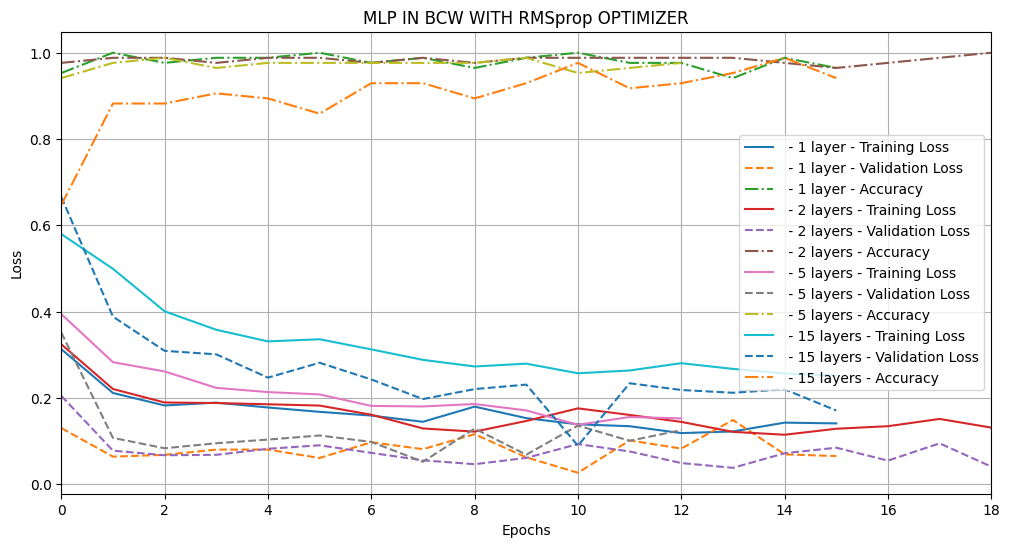

In [14]:
utilsTFG.plot_learners_training(learners['RMSProp'].values(), title='MLP IN BCW WITH RMSprop OPTIMIZER', names=names_layer)

### Adam

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.871111,0.727534,0.400000,00:00
1,0.774883,0.571960,0.752941,00:00
2,0.652661,0.449973,0.905882,00:00
3,0.550156,0.357616,0.905882,00:00
4,0.456443,0.269135,0.964706,00:00
5,0.378530,0.214487,0.964706,00:00
6,0.309676,0.177187,0.964706,00:00
7,0.262109,0.146078,0.964706,00:00
8,0.230973,0.132006,0.988235,00:00
9,0.204757,0.099856,0.988235,00:00


Better model found at epoch 0 with valid_loss value: 0.7275340557098389.
Better model found at epoch 1 with valid_loss value: 0.5719603300094604.
Better model found at epoch 2 with valid_loss value: 0.449972927570343.
Better model found at epoch 3 with valid_loss value: 0.35761550068855286.
Better model found at epoch 4 with valid_loss value: 0.2691349387168884.
Better model found at epoch 5 with valid_loss value: 0.2144872099161148.
Better model found at epoch 6 with valid_loss value: 0.17718744277954102.
Better model found at epoch 7 with valid_loss value: 0.14607828855514526.
Better model found at epoch 8 with valid_loss value: 0.13200588524341583.
Better model found at epoch 9 with valid_loss value: 0.09985597431659698.
Better model found at epoch 11 with valid_loss value: 0.09241710603237152.
Better model found at epoch 12 with valid_loss value: 0.07769131660461426.
Better model found at epoch 13 with valid_loss value: 0.0754178911447525.
Better model found at epoch 14 with valid_

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.556901,0.593527,0.741176,00:00
1,0.464777,0.404560,0.894118,00:00
2,0.396592,0.362714,0.870588,00:00
3,0.333684,0.258676,0.929412,00:00
4,0.287978,0.232920,0.941176,00:01
5,0.238906,0.194828,0.929412,00:00
6,0.206936,0.149028,0.976471,00:01
7,0.202167,0.200931,0.952941,00:00
8,0.194220,0.113062,0.976471,00:00
9,0.185550,0.104433,0.976471,00:00


Better model found at epoch 0 with valid_loss value: 0.5935269594192505.
Better model found at epoch 1 with valid_loss value: 0.4045604467391968.
Better model found at epoch 2 with valid_loss value: 0.3627142906188965.
Better model found at epoch 3 with valid_loss value: 0.25867581367492676.
Better model found at epoch 4 with valid_loss value: 0.23292025923728943.
Better model found at epoch 5 with valid_loss value: 0.19482798874378204.
Better model found at epoch 6 with valid_loss value: 0.1490282118320465.
Better model found at epoch 8 with valid_loss value: 0.1130620613694191.
Better model found at epoch 9 with valid_loss value: 0.10443270206451416.
Better model found at epoch 11 with valid_loss value: 0.04985684156417847.
No improvement since epoch 11: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.565796,0.539538,0.858824,00:00
1,0.434590,0.318972,0.894118,00:00
2,0.391045,0.300800,0.905882,00:01
3,0.335470,0.245064,0.905882,00:00
4,0.281644,0.162277,0.952941,00:00
5,0.255202,0.131926,0.952941,00:00
6,0.255226,0.133664,0.952941,00:00
7,0.217726,0.140068,0.952941,00:00
8,0.202906,0.115474,0.976471,00:00
9,0.179442,0.140849,0.941176,00:00


Better model found at epoch 0 with valid_loss value: 0.5395382642745972.
Better model found at epoch 1 with valid_loss value: 0.31897175312042236.
Better model found at epoch 2 with valid_loss value: 0.3007999658584595.
Better model found at epoch 3 with valid_loss value: 0.24506396055221558.
Better model found at epoch 4 with valid_loss value: 0.16227734088897705.
Better model found at epoch 5 with valid_loss value: 0.13192623853683472.
Better model found at epoch 8 with valid_loss value: 0.11547434329986572.
Better model found at epoch 11 with valid_loss value: 0.08333393186330795.
Better model found at epoch 15 with valid_loss value: 0.07068444788455963.
Better model found at epoch 19 with valid_loss value: 0.061209116131067276.
No improvement since epoch 19: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

epoch,train_loss,valid_loss,accuracy,time
0,0.613729,0.694955,0.494118,00:02
1,0.547340,0.538546,0.776471,00:02
2,0.507262,0.472141,0.788235,00:02
3,0.475463,0.396217,0.823529,00:02
4,0.436029,0.436020,0.823529,00:03
5,0.404284,0.374252,0.882353,00:02
6,0.379333,0.338391,0.882353,00:02
7,0.342189,0.263343,0.941176,00:02
8,0.328332,0.298049,0.917647,00:02
9,0.317047,0.224503,0.917647,00:02


Better model found at epoch 0 with valid_loss value: 0.6949552893638611.
Better model found at epoch 1 with valid_loss value: 0.5385462641716003.
Better model found at epoch 2 with valid_loss value: 0.4721408188343048.
Better model found at epoch 3 with valid_loss value: 0.3962172865867615.
Better model found at epoch 5 with valid_loss value: 0.37425166368484497.
Better model found at epoch 6 with valid_loss value: 0.3383905291557312.
Better model found at epoch 7 with valid_loss value: 0.2633431851863861.
Better model found at epoch 9 with valid_loss value: 0.22450287640094757.
Better model found at epoch 10 with valid_loss value: 0.2092570811510086.
Better model found at epoch 12 with valid_loss value: 0.12988978624343872.
Better model found at epoch 14 with valid_loss value: 0.12927143275737762.
No improvement since epoch 14: early stopping


/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

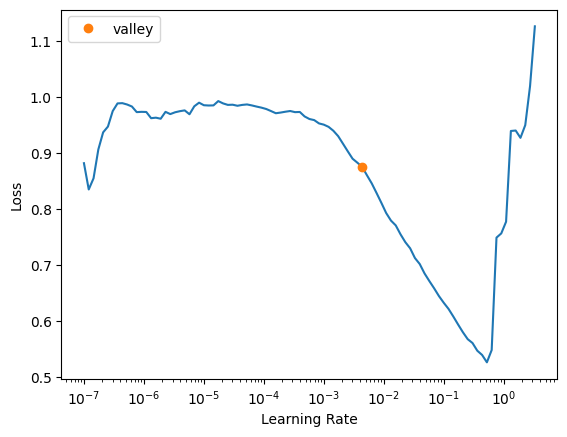

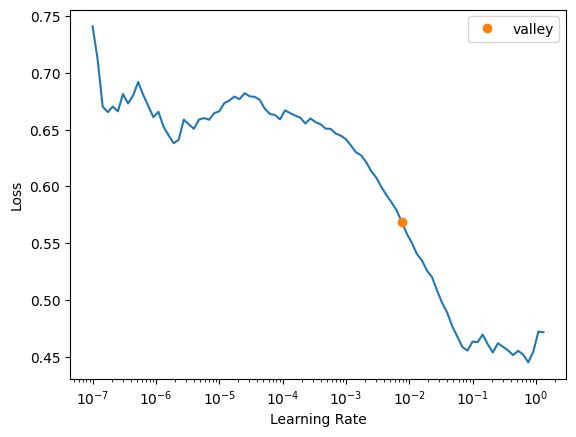

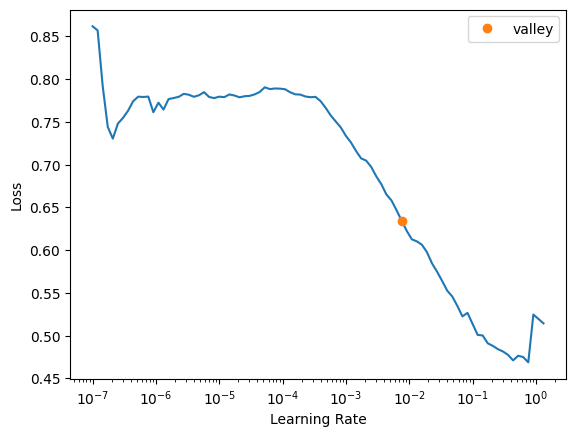

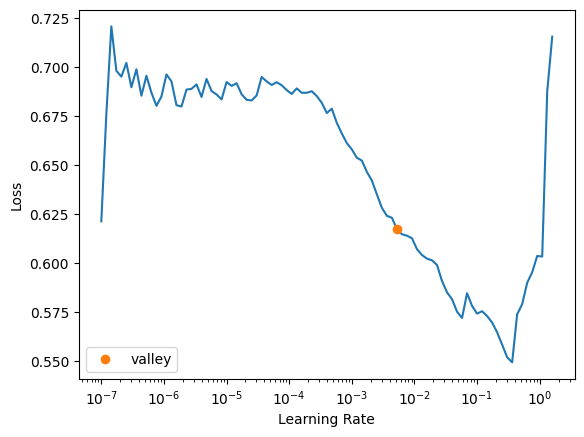

In [15]:
for _, learner in learners['ADAM'].items():
  lr=learner.lr_find()
  learner.fit_one_cycle(100, lr)


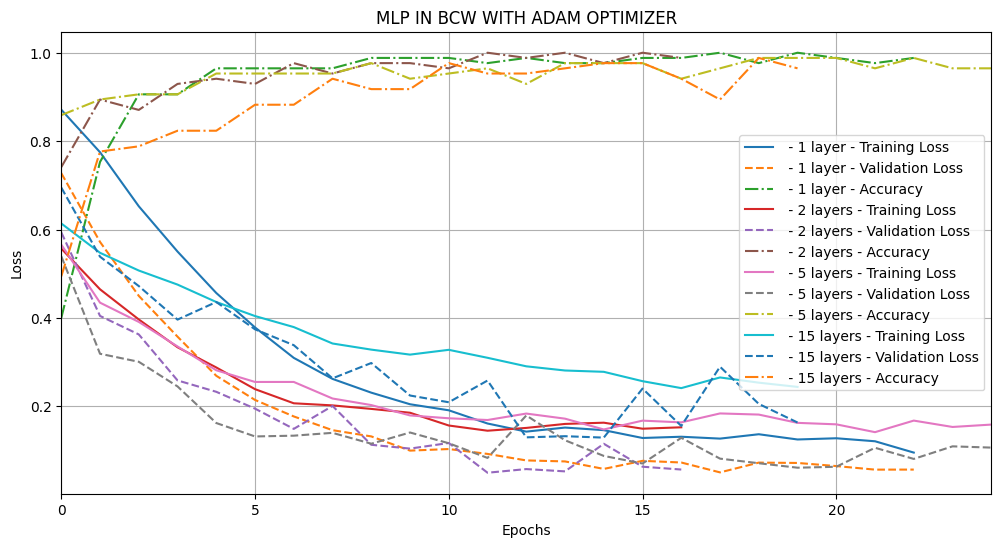

In [16]:
utilsTFG.plot_learners_training(learners['ADAM'].values(), title='MLP IN BCW WITH ADAM OPTIMIZER', names=names_layer)

### Save or Load models

In [17]:
#Save the trained learners
file_path = '/content/drive/MyDrive/learners_dict.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(learners, f)

In [24]:
#Load the trained learners
file_path = '/content/drive/MyDrive/learners_dict.pkl'
with open(file_path, 'rb') as f:
    learners = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


### Comparative per layers

In [27]:
#Compare the three optimizers in each layer version

learners_1_layer = [learners['NAG'][1], learners['RMSProp'][1], learners['ADAM'][1]]
learners_2_layers = [learners['NAG'][2], learners['RMSProp'][2], learners['ADAM'][2]]
learners_5_layers = [learners['NAG'][5], learners['RMSProp'][5], learners['ADAM'][5]]
learners_15_layers = [learners['NAG'][15], learners['RMSProp'][15], learners['ADAM'][15]]

names=['NAG', 'RMSProp', 'ADAM']
utilsTFG.plot_learners_training(learners_1_layer, title='MLP IN BCW WITH 1 LAYER', names=names)
utilsTFG.plot_learners_training(learners_2_layers, title='MLP IN BCW WITH 2 LAYERS', names=names)
utilsTFG.plot_learners_training(learners_5_layers, title='MLP IN BCW WITH 5 LAYERS', names=names)
utilsTFG.plot_learners_training(learners_15_layers, title='MLP IN BCW WITH 10 LAYERS', names=names)

TypeError: plot_learners_training2() got an unexpected keyword argument 'names'

### Generalization

In [20]:
#Run the model in the test set
for optim in optims:
  for layer in n_layers:
    #Run the model with optimizer optim and n_layers layer the test set in evaluation mode
    learners[optim][layer].model.eval()
    learners[optim][layer].eval()
    preds, targs = learners[optim][layer].get_preds(dl=test_dl)
    targs = targs.long().squeeze()

    # Calculate accuracy
    correct = (preds.argmax(dim=1) == targs).sum()
    total = targs.size(0)
    accuracy = correct / total

    loss = utilsTFG.err_param_w_model(learners[optim][layer].model, test_dl, mode = 'test')


    print(f"Optimizer: {optim}, Layers: {layer}, Loss: {loss}, Accuracy: {accuracy.item()}")

Optimizer: NAG, Layers: 1, Loss: 0.19335274398326874, Accuracy: 0.929411768913269


Optimizer: NAG, Layers: 2, Loss: 0.22082793712615967, Accuracy: 0.9176470637321472


Optimizer: NAG, Layers: 5, Loss: 0.22879232466220856, Accuracy: 0.8941176533699036


Optimizer: NAG, Layers: 15, Loss: 0.346419095993042, Accuracy: 0.8941176533699036


Optimizer: RMSProp, Layers: 1, Loss: 0.22678524255752563, Accuracy: 0.9176470637321472


Optimizer: RMSProp, Layers: 2, Loss: 0.1837242692708969, Accuracy: 0.929411768913269


Optimizer: RMSProp, Layers: 5, Loss: 0.16642652451992035, Accuracy: 0.929411768913269


Optimizer: RMSProp, Layers: 15, Loss: 0.3163524568080902, Accuracy: 0.8941176533699036


Optimizer: ADAM, Layers: 1, Loss: 0.19579948484897614, Accuracy: 0.929411768913269


Optimizer: ADAM, Layers: 2, Loss: 0.2944524586200714, Accuracy: 0.9058823585510254


Optimizer: ADAM, Layers: 5, Loss: 0.262026846408844, Accuracy: 0.8705882430076599


Optimizer: ADAM, Layers: 15, Loss: 0.3013400733470917, Accuracy: 0.8941176533699036


## Metaheuristics

In [35]:
import copy
#layer=[16,32,64, 64,32,16]
pop_size=10
population = {}
fitness = {}
mh_learners = {}
results = {}
fitness_valid = {}
best = {}

for n_layer,layer in zip(n_layers,layers):
  population[n_layer] = []
  mh_learners[n_layer] = tabular_learner(dls, layers=layer, cbs=[SaveModelCallback()])
  for _ in range(pop_size):
    model_copy = copy.deepcopy(mh_learners[n_layer].model)

    # Reset the weights of the model copy
    model_copy.apply(utilsTFG.reset_weights)

    # Add the reinitialized model to the population list
    population[n_layer].append(utilsTFG.get_params_from_model(model_copy))

for alg in algs:
  results[alg] = {}
  fitness_valid[alg] = {}
  best[alg] = {}


### Genetic Algorithms

In [ ]:
#Genetic Algorithm working as supposed to (terrible performance)
results['GA'] = {}
for layer in n_layers:
  results['GA'][layer] = utilsTFG.gen_alg(pop_size, copy.deepcopy(population[layer]), dls, 4000, mh_learners[layer])

KeyboardInterrupt: 

### SHADE

In [ ]:
#SHADE alg not working completely wrong
results['SHADE'] = {}
for layer in n_layers:
  results['SHADE'][layer] = utilsTFG.SHADE_ej(copy.deepcopy(population[layer]), fitness[layer], pop_size,500, len(population[0]), dls,  model=mh_learners[layer].model)


In [ ]:
#Validate the models obtained.

for layer in n_layers:
  fitness_valid['SHADE'] = []
  for ind in results['SHADE'][layer][0]:
    fitness_valid[layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [ ]:
#compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE for {layer} layers: {results['SHADE'][layer][1]}")
  print(f"Validation error of SHADE for {layer} layers: {fitness_valid['SHADE'][layer]}")
  dif = fitness_valid['SHADE'][layer] - results['SHADE'][layer][1]
  print(f"Difference: {dif}")
  mejor = np.argmin(dif)+1
  best['SHADE'][layer] = results['SHADE'][layer][1][mejor]
  print(f"Best generalizing model: Model {mejor} (1-10)")
  #Compare test

  print("\n")

### SHADE-ILS

In [ ]:
# Working fine
results['SHADE-ILS'] = {}
for layer in n_layers:
  results['SHADE-ILS'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)


In [ ]:
#Validation error
fitness_valid['SHADE-ILS'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS'][layer] = []
  for ind in results['SHADE-ILS'][layer][3]:
    fitness_valid['SHADE-ILS'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [ ]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS for {layer} layers: {results['SHADE-ILS'][layer][2]}")
  print(f"Validation error of SHADE-ILS for {layer} layers: {fitness_valid['SHADE-ILS'][layer]}")
  dif = fitness_valid['SHADE-ILS'][layer] - results['SHADE-ILS'][layer][2]
  print(f"Difference: {dif}")
  mejor = np.argmin(dif)+1
  best['SHADE-ILS'][layer] = results['SHADE-ILS'][layer][2][mejor]
  print(f"Best generalizing model: Model {mejor} (1-10)")
  print("\n")

### SHADE-GD

In [ ]:
# Working ???
results['SHADE-GD'] = {}
for layer in n_layers:
  results['SHADE-GD'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model)


In [ ]:
#Validation error
fitness_valid['SHADE-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-GD'][layer] = []
  for ind in results['SHADE-GD'][layer][3]:
    fitness_valid['SHADE-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [ ]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-GD for {layer} layers: {results['SHADE-GD'][layer][2]}")
  print(f"Validation error of SHADE-GD for {layer} layers: {fitness_valid['SHADE-GD'][layer]}")
  dif = fitness_valid['SHADE-ILS'][layer] - results['SHADE-GD'][layer][2]
  print(f"Difference: {dif}")
  mejor = np.argmin(dif)+1
  best['SHADE-GD'][layer] = results['SHADE-GD'][layer][1][mejor]
  print(f"Best generalizing model: Model {mejor} (1-10)")
  print("\n")

### SHADE-ILS-GD

In [ ]:
# Working ???
results['SHADE-ILS-GD'] = {}
for layer in n_layers:
  results['SHADE-ILS-GD'][layer] = utilsTFG.SHADE_ILS(copy.deepcopy(population[layer]), max_evals, max_evals_shade, dls, mh_learners[layer], mh_learners[layer].model, max_ls=max_ls)


In [ ]:
#Validation error
fitness_valid['SHADE-ILS-GD'] = {}
for layer in n_layers:
  fitness_valid['SHADE-ILS-GD'][layer] = []
  for ind in results['SHADE-ILS-GD'][layer][3]:
    fitness_valid['SHADE-ILS-GD'][layer].append(utilsTFG.err_param_valid(ind, mh_learners[layer].model, dls))

In [ ]:
#Compare train and valid
for layer in n_layers:
  print(f"Training error of SHADE-ILS-GD for {layer} layers: {results['SHADE-ILS-GD'][layer][2]}")
  print(f"Validation error of SHADE-ILS-GD for {layer} layers: {fitness_valid['SHADE-ILS-GD'][layer]}")
  dif = fitness_valid['SHADE-ILS-GD'][layer] - results['SHADE-ILS-GD'][layer][2]
  print(f"Difference: {dif}")
  mejor = np.argmin(dif)+1
  best['SHADE-ILS-GD'][layer] = results['SHADE-ILS-GD'][layer][1][mejor]
  print(f"Best generalizing model: Model {mejor} (1-10)")
  print("\n")